
# Feature Selection Example:
## Vehicle Reservations
  
 > ## Heather M. Steich, M.S.  
 > ## March 26$^{th}$, 2017

In [1]:
## LOAD LIBRARIES:

# Data wrangling & processing: 
import numpy as np
import pandas as pd

# Machine learning:
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

# Plotting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warning messages:
import warnings
warnings.filterwarnings('ignore')

In [2]:
## ESTABLISH PLOT FORMATTING:

#mpl.rcdefaults()  # Resets plot defaults

def plt_format():
    %matplotlib inline
    plt.rcParams['figure.figsize'] = (16, 10)
    plt.rcParams['font.size'] = 16
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 32
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['legend.fontsize'] = 16
    plt.rcParams['legend.markerscale'] = 4
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams['legend.fontsize'] = 16
    plt.rcParams['legend.frameon'] = False
    plt.rcParams['axes.linewidth'] = 1

#plt.rcParams.keys()  # Available rcParams
plt_format()

In [3]:
## LOAD DATA:

# Read CSV file for Reservation & Vehicle Data:
reservations = pd.read_csv("./Data/Reservations.csv")
vehicles = pd.read_csv("./Data/Vehicles.csv")

# Print shapes:
print('Reservations CSV Shape:', reservations.shape)
print('Reservations Column Names:', reservations.columns)
print('Vehicles CSV Shape:', vehicles.shape)
print('Vehicles Column Names:', vehicles.columns)

Reservations CSV Shape: (6376, 2)
Reservations Column Names: Index(['vehicle_id', 'reservation_type'], dtype='object')
Vehicles CSV Shape: (1000, 7)
Vehicles Column Names: Index(['vehicle_id', 'technology', 'actual_price', 'recommended_price',
       'num_images', 'street_parked', 'description'],
      dtype='object')


In [4]:
## CALCULATE THE TOTAL NUMBER OF RESERVATIONS FOR EACH VEHICLE_ID:

# Add a basic column of 1's for every reservation:
reservations['total_reservations'] = 1

# Aggregate the vehicle_id's by summing the reservation counts:
# Reset the index of the newly created DataFrame:
# Drop the reservation_type column which is not needed for the problem:
reso_totals = reservations.groupby(by='vehicle_id').sum().reset_index().drop('reservation_type', axis=1)

# Print a preview of the reso_totals DataFrame:
print('Breakdown of Reservation Totals: \n', reso_totals.describe())
reso_totals.head(3)

Breakdown of Reservation Totals: 
         vehicle_id  total_reservations
count   911.000000          911.000000
mean    494.600439            6.998902
std     288.242005            4.645333
min       1.000000            1.000000
25%     245.500000            3.000000
50%     493.000000            6.000000
75%     739.500000           10.000000
max    1000.000000           25.000000


,vehicle_id,total_reservations
0,1,1
1,2,7
2,3,17


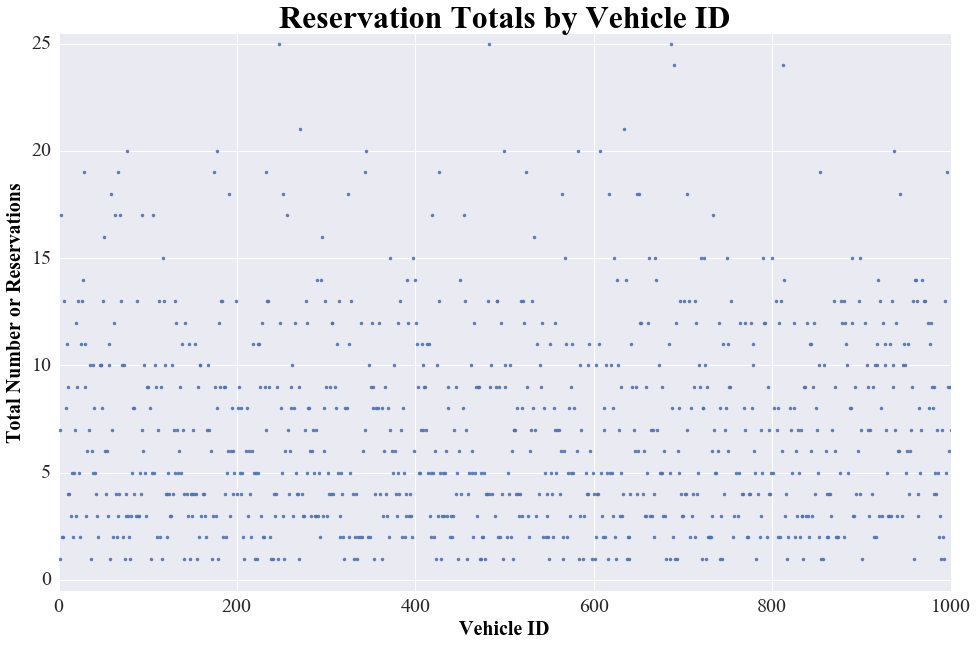

In [5]:
## VISUALIZE THE RESERVATIONS:

# Use pre-specified plot format:
plt_format()

# Plot the vehicle_id's against the total_reservations:
plt.plot(reso_totals.vehicle_id, reso_totals.total_reservations, '.', alpha=0.9)
plt.xlim(-0.5, 1000.5)
plt.ylim(-0.5, 25.5)
plt.title('Reservation Totals by Vehicle ID')
plt.xlabel('Vehicle ID')
plt.ylabel('Total Number or Reservations');

In [6]:
## MERGE THE VEHICLES & RESO_TOTALS DATAFRAMES:

# Merge via left outer join on vehicle_id:
df = vehicles.merge(reso_totals, how='left', on='vehicle_id')

# Some vehicle_id's did not have any reservations; convert the 'NAN's to 0's:
df.total_reservations.fillna(value=0, inplace=True)

# Convert the total_reservations to integers:
df.total_reservations = df.total_reservations.astype(int)

# Print a preview of the final DataFrame:
df.head(3)

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,total_reservations
0,1,1,67.85,59,5,0,7,1
1,2,0,100.70,53,5,0,224,7
2,3,0,74.00,74,4,1,21,17


In [7]:
## CHECK THE LINEAR CORRELATIONS OF THE DATAFRAME:

df.corr()

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,total_reservations
vehicle_id,1.000000,-0.015705,-0.015671,-0.009959,-0.035756,0.053613,-0.058031,-0.001673
technology,-0.015705,1.000000,-0.461930,-0.411390,-0.004660,-0.004633,0.033000,0.136471
actual_price,-0.015671,-0.461930,1.000000,0.759358,-0.064753,0.004764,-0.015089,-0.258907
recommended_price,-0.009959,-0.411390,0.759358,1.000000,-0.046492,0.013034,0.012820,-0.012758
num_images,-0.035756,-0.004660,-0.064753,-0.046492,1.000000,-0.006065,0.010074,0.219804
street_parked,0.053613,-0.004633,0.004764,0.013034,-0.006065,1.000000,-0.008186,-0.016525
description,-0.058031,0.033000,-0.015089,0.012820,0.010074,-0.008186,1.000000,0.016303
total_reservations,-0.001673,0.136471,-0.258907,-0.012758,0.219804,-0.016525,0.016303,1.000000


In [8]:
## BIN THE RESERVATIONS TO MAKE CLASSIFICATIONS:

# Specify bins to group the number of reservations & create labels:
bins = [-1, 5, 10, 15, 20, 25]
groups = ['0 - 5', '6 - 10', '11 - 15', '16 - 20', '21 - 25']
cats = [1, 2, 3, 4, 5]

# Add extra columns & insert the binned data:
categories = pd.cut(df['total_reservations'], bins, labels=groups)
df['categories'] = pd.cut(df['total_reservations'], bins, labels=groups)
reservation_cat = pd.cut(df['total_reservations'], bins, labels=cats)
df['reservation_cat'] = pd.cut(df['total_reservations'], bins, labels=cats)

# Print the column names contained in df:
print('Column Names: ')
df.columns

Column Names: 


Index(['vehicle_id', 'technology', 'actual_price', 'recommended_price',
       'num_images', 'street_parked', 'description', 'total_reservations',
       'categories', 'reservation_cat'],
      dtype='object')

In [9]:
## DEFINE INPUT & OUTPUT VARIABLES:

# Eliminate vehicle_id as it is a unique identifier as well as all output variables:
X = df.drop(['vehicle_id', 'total_reservations', 'categories', 'reservation_cat'], axis=1)

# Identify both the numeric & categorical outputs for comparison:
y1, y2 = df.total_reservations, df.reservation_cat

# Print the first row of the input features for reference:
print(X.iloc[0, :])

technology            1.00
actual_price         67.85
recommended_price    59.00
num_images            5.00
street_parked         0.00
description           7.00
Name: 0, dtype: float64


In [10]:
## DEFINE A FUNCTION THAT IDENTIFIES WHICH FEATURE(S) IS(ARE) SELECTED:

def identify(output):
    list = []
    for i in range(len(X.columns)):
        for j in range(output.shape[1]):
            if output[0, j] == X.iloc[0, i]:
                list.append(X.columns[i])
    print(list)            

In [11]:
# UNIVARIATE FEATURE SELECTION:

# Select 'k' best using chi-squared:
output = SelectKBest(chi2, k=1).fit_transform(X, y1)
print('Best 1 Feature, total_reservations: ')
identify(output)

output = SelectKBest(chi2, k=1).fit_transform(X, y2)
print('Best 1 Feature, reservation_cat: ')
identify(output)

output = SelectKBest(chi2, k=2).fit_transform(X, y1)
print('\nBest 2 Features, total_reservations: ')
identify(output)

output = SelectKBest(chi2, k=2).fit_transform(X, y2)
print('Best 2 Features, reservation_cat: ')
identify(output)

Best 1 Feature, total_reservations: 
['description']
Best 1 Feature, reservation_cat: 
['actual_price']

Best 2 Features, total_reservations: 
['actual_price', 'description']
Best 2 Features, reservation_cat: 
['actual_price', 'description']


In [12]:
## LOGIT CLASSIFIER FOR FEATURE SELECTION:

# Using logistic regression:
linear = LogisticRegression(C=0.0001, penalty="l2", solver='sag', dual=False).fit(X, y1)
output = SelectFromModel(linear, prefit=True).transform(X)
print('Best 2 Features, total_reservations: ')
identify(output)

linear = LogisticRegression(C=0.0001, penalty="l2", solver='sag', dual=False).fit(X, y2)
print('Best 2 Features, reservation_cat: ')
identify(output)

Best 2 Features, total_reservations: 
['actual_price', 'recommended_price']
Best 2 Features, reservation_cat: 
['actual_price', 'recommended_price']


In [13]:
## TREE-BASED FEATURE SELECTION:

# Ensemble model tree-based estimators compute relative importance of each attribute:
clf = ExtraTreesClassifier().fit(X, y1)
print('Feature Importance Scores: ', clf.feature_importances_)
output = SelectFromModel(clf, prefit=True).transform(X)
print('Best 3 Features, total_reservations: ')
identify(output)
print('Order of Importance = Actual Price, Description Length, Recommended Price \n')

clf = ExtraTreesClassifier().fit(X, y2)
print('Feature Importance Scores: ', clf.feature_importances_)
output = SelectFromModel(clf, prefit=True).transform(X)
print('Best 3 Features, reservation_cat: ')
identify(output)
print('Order of Importance = Actual Price, Recommended Price, Description Length')

Feature Importance Scores:  [ 0.01029566  0.30423809  0.27604841  0.09108969  0.02419317  0.29413499]
Best 3 Features, total_reservations: 
['actual_price', 'recommended_price', 'description']
Order of Importance = Actual Price, Description Length, Recommended Price 

Feature Importance Scores:  [ 0.01421552  0.31242244  0.25888497  0.12284067  0.03659882  0.25503757]
Best 3 Features, reservation_cat: 
['actual_price', 'recommended_price', 'description']
Order of Importance = Actual Price, Recommended Price, Description Length


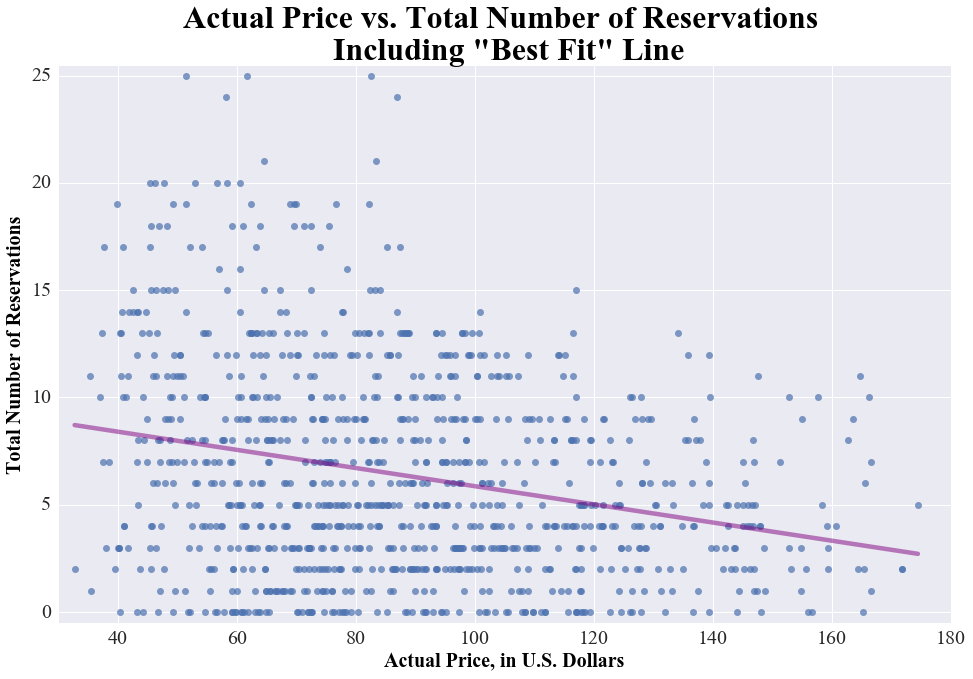

In [14]:
## VISUALIZE THE RESERVATIONS:

# Use pre-specified plot format:
plt_format()

# Plot the vehicle_id's against the total_reservations:
plt.plot(df.actual_price, df.total_reservations, 'o', alpha=0.7)
plt.plot(np.unique(df.actual_price), 
         np.poly1d(np.polyfit(df.actual_price, df.total_reservations, 1))
        (np.unique(df.actual_price)),
        linewidth=4.5, color='purple', alpha=0.5)
plt.xlim(30, 180)
plt.ylim(-0.5, 25.5)
plt.title('Actual Price vs. Total Number of Reservations \n Including "Best Fit" Line')
plt.xlabel('Actual Price, in U.S. Dollars')
plt.ylabel('Total Number of Reservations');

In [15]:
## LINEAR NORMALIZATION:

# Re-assign DataFrame to another variable:
to_normalize = pd.DataFrame(df)

# Select numeric features to normalize:
x = ['vehicle_id', 'technology', 'actual_price', 'recommended_price',
       'num_images', 'street_parked', 'description', 'total_reservations',
       'reservation_cat']

# Normalize the dataset:
df_norm = pd.DataFrame((to_normalize[x].values - to_normalize[x].min().values) 
                       / (to_normalize[x].max().values - to_normalize[x].min().values), 
                       columns=to_normalize[x].columns).astype('float')
df_norm = pd.concat([to_normalize['categories'], df_norm], axis=1)

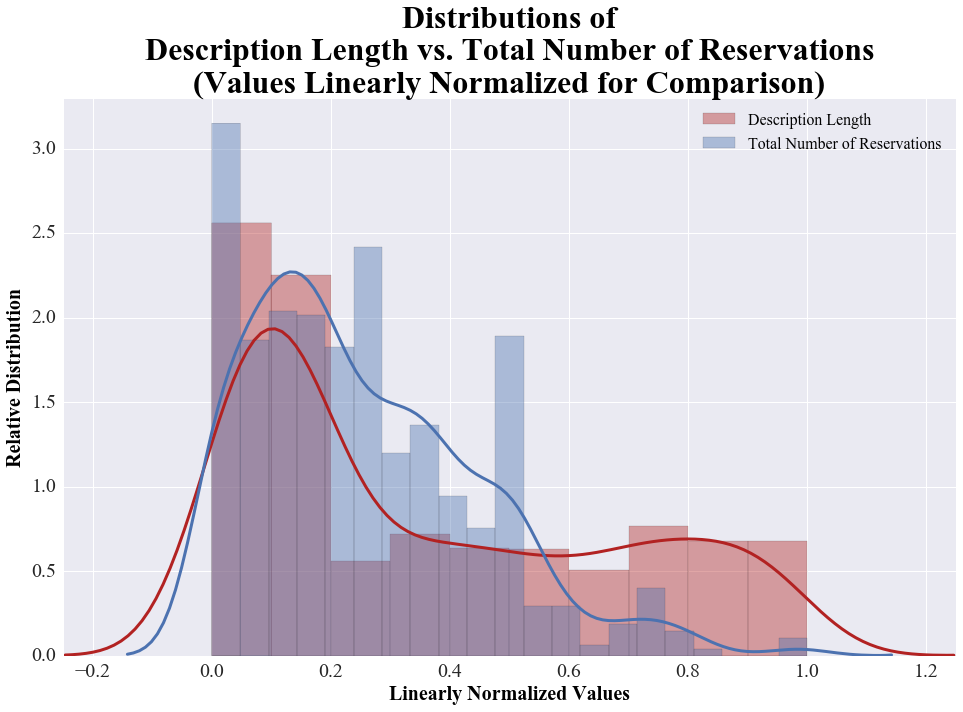

In [16]:
## VISUALIZE THE DESCRIPTIONS:

# Use pre-specified plot format:
plt_format()
mpl.rcParams['lines.linewidth'] = 3

# Plot the description lengths against the total_reservations:
sns.distplot(df_norm.description, color='firebrick', label='Description Length')
sns.distplot(df_norm.total_reservations, label='Total Number of Reservations')
plt.xlim(-0.25, 1.25)
plt.ylim(0, 3.3)
plt.title('Distributions of\nDescription Length vs. Total Number of Reservations\n(Values Linearly Normalized for Comparison)')
plt.xlabel('Linearly Normalized Values')
plt.ylabel('Relative Distribution')
plt.legend();

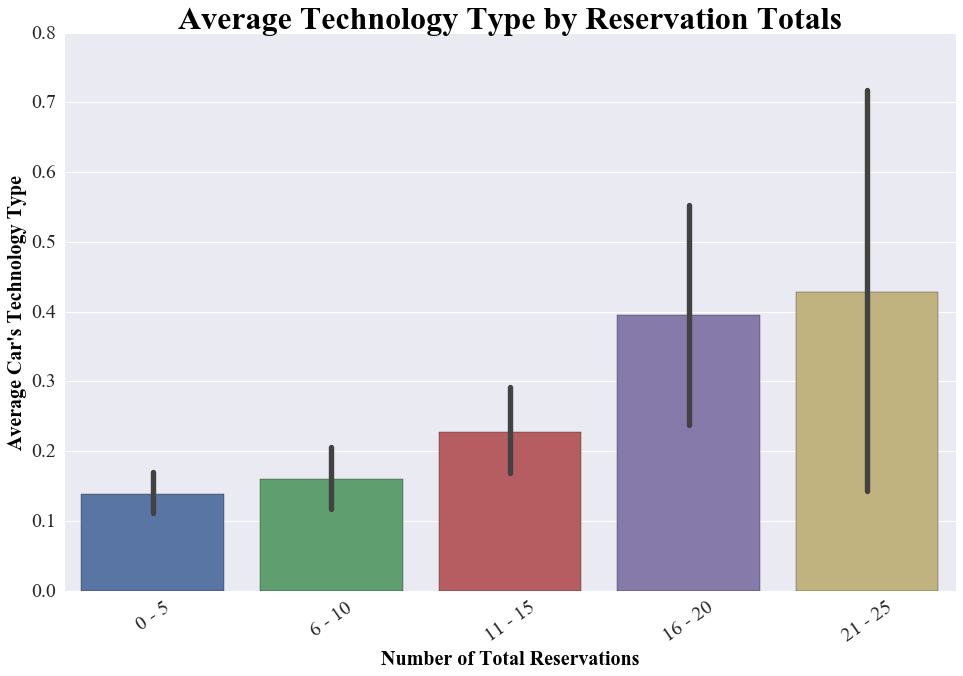

In [17]:
## VISUALIZE THE RESERVATIONS:

# Use pre-specified plot format:
plt_format()

# Plot the bins:
sns.barplot(x='categories', y='technology', data=df)
plt.title('Average Technology Type by Reservation Totals')
plt.xlabel('Number of Total Reservations')
plt.ylabel("Average Car's Technology Type")
plt.xticks(rotation=35);

In [18]:
## PRINT STATISTICS FOR EACH CATEGORY:

print('Number of Reservations 0 - 5:  ', len(categories[categories == '0 - 5']))
print('Number of Reservations 6 - 10: ', len(categories[categories == '6 - 10']))
print('Number of Reservations 11 - 15:', len(categories[categories == '11 - 15']))
print('Number of Reservations 16 - 20:', len(categories[categories == '16 - 20']))
print('Number of Reservations 21 - 25:', len(categories[categories == '21 - 25']))

print('\nPercentage of Vehicles with "Instantly Bookable" Technology:', (df.technology.sum() / len(df)) * 100, '%')

Number of Reservations 0 - 5:   519
Number of Reservations 6 - 10:  282
Number of Reservations 11 - 15: 154
Number of Reservations 16 - 20: 38
Number of Reservations 21 - 25: 7

Percentage of Vehicles with "Instantly Bookable" Technology: 17.0 %


In [19]:
## MERGE RESERVATION & VEHICLE DATAFRAMES TO INCLUDE TECHNOLOGY:

# Merge DataFrames:
df2 = reservations.merge(vehicles, how='left', on='vehicle_id')

# Group by reservation_type & aggregate on total_reservations & technology:
df3 = df2.groupby(by='reservation_type').sum().reset_index().drop(['vehicle_id', 
                'actual_price', 'recommended_price', 
                'num_images', 'street_parked', 'description'], axis=1)

# Print Reservation DataFrame grouped by type & including technology counts:
df3

,reservation_type,total_reservations,technology
0,1,2339,650
1,2,2057,352
2,3,1980,331


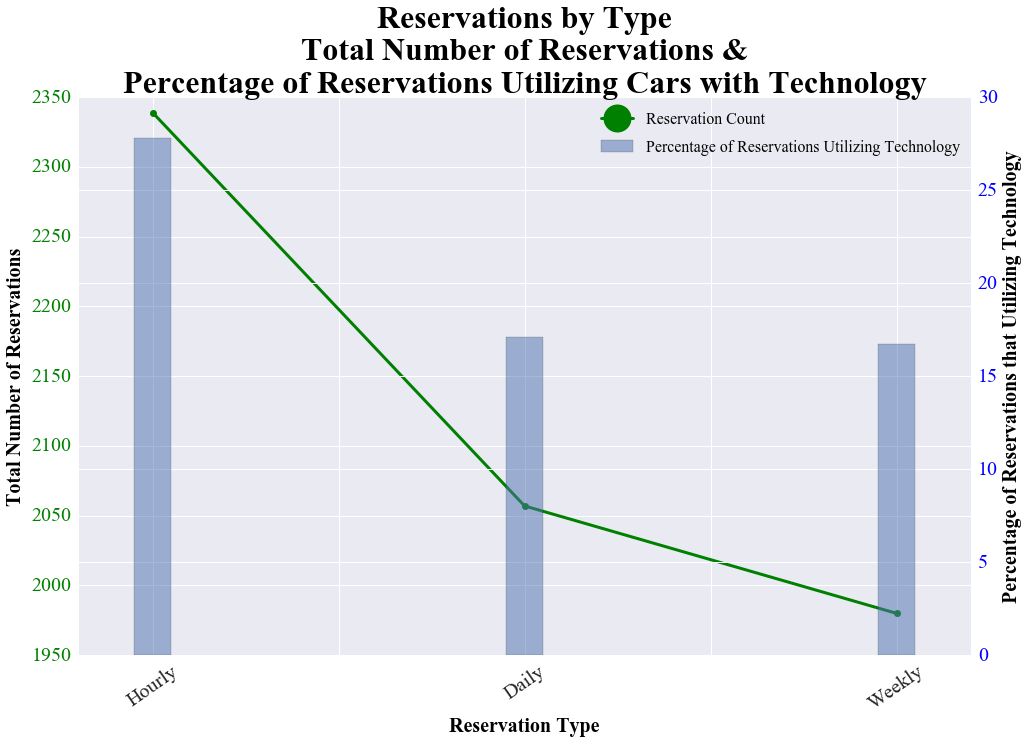

In [20]:
## PLOT RESERVATION TYPES IN RELATION TO TECHNOLOGY:

# Use pre-specified plot format:
plt_format()
fig, ax1 = plt.subplots()

# Plot both data sources:
ax1.plot(df3.reservation_type, df3.total_reservations, color='green', marker='o', label='Reservation Count')
ax2 = ax1.twinx()
ax2.bar(df3.reservation_type-0.05, ((df3.technology.values / df3.total_reservations.values)*100), 
        width=0.1, alpha=0.5, label='Percentage of Reservations Utilizing Technology')

plt.title('Reservations by Type\nTotal Number of Reservations &\nPercentage of Reservations Utilizing Cars with Technology')

plt.xlim(0.8, 3.2)
ax1.set_xlabel('Reservation Type')
types = ['', 'Hourly', '', 'Daily', '', 'Weekly']
ax1.set_xticklabels(types, rotation=35)

ax1.set_ylabel('Total Number of Reservations')
ax1.tick_params('y', colors='g')
ax2.set_ylabel('Percentage of Reservations that Utilizing Technology')
ax2.tick_params('y', colors='b')

ax1.legend(bbox_to_anchor=(0.57, 1), loc=2)
ax2.legend(bbox_to_anchor=(0.57, 0.95), loc=2);

---  
  
# Summary
  
 - **The most important factor driving reservation totals is the actual price.  A lower price results in more reservations.**  
 
 - **Technology has a positive affect on reservation totals.**  
  
 - **More data, with better distributions across reservation totals could strengthen the analyses.  Similarly, adding other features such as seasonality, location & client demographics should be explored.**  
